<a href="https://colab.research.google.com/github/EstelHoshi/FirstRepo/blob/master/Test_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading

In [ ]:
import pandas as pd
from pprint import pprint
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sn

import tensorflow as tf
from keras.optimizers import SGD
from keras.optimizers.schedules import ExponentialDecay
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization

from tensorflow.keras.models import load_model

## Download and uncompress dataset and metadata

In [ ]:
!wget -nc https://storage.hpai.bsc.es/mame-dataset/MAMe_data_256.zip
!wget -nc https://storage.hpai.bsc.es/mame-dataset/MAMe_metadata.zip
!unzip -oqq MAMe_data_256.zip
!unzip -oqq MAMe_metadata.zip

--2021-04-18 15:26:03--  https://storage.hpai.bsc.es/mame-dataset/MAMe_data_256.zip
Resolving storage.hpai.bsc.es (storage.hpai.bsc.es)... 84.88.186.2
Connecting to storage.hpai.bsc.es (storage.hpai.bsc.es)|84.88.186.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 723471982 (690M) [application/zip]
Saving to: ‘MAMe_data_256.zip’

MAMe_data_256.zip   100%[===================>] 689.96M  24.8MB/s    in 2m 32s  

2021-04-18 15:28:36 (4.52 MB/s) - ‘MAMe_data_256.zip’ saved [723471982/723471982]

--2021-04-18 15:28:36--  https://storage.hpai.bsc.es/mame-dataset/MAMe_metadata.zip
Resolving storage.hpai.bsc.es (storage.hpai.bsc.es)... 84.88.186.2
Connecting to storage.hpai.bsc.es (storage.hpai.bsc.es)|84.88.186.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 868837 (848K) [application/zip]
Saving to: ‘MAMe_metadata.zip’

MAMe_metadata.zip   100%[===================>] 848.47K  1.38MB/s    in 0.6s    

2021-04-18 15:28:37 (1.38 MB/s) - ‘MAM

In [ ]:
metadata = pd.read_csv('./MAMe_dataset.csv')
# Only mantain the columns to be used
metadata = metadata[['Subset', 'Image file', 'Medium']]

train_metadata = metadata[metadata['Subset'] == 'train'].copy()
train_metadata.drop('Subset', inplace=True, axis=1)
val_metadata = metadata[metadata['Subset'] == 'val'].copy()
val_metadata.drop('Subset', inplace=True, axis=1)
test_metadata = metadata[metadata['Subset'] == 'test'].copy()
test_metadata.drop('Subset', inplace=True, axis=1)
del metadata

labels = set(train_metadata['Medium'].to_list())
label_test = test_metadata['Medium'].to_list()
print('Labels ({n_labels}):'.format(n_labels=len(labels)))
pprint(labels)

print("Number of images (train): ", len(train_metadata))
print("Number of images (val): ", len(val_metadata))
print("Number of images (test): ", len(test_metadata))

print(np.shape(label_test))

Labels (29):
{'Albumen photograph',
 'Bronze',
 'Ceramic',
 'Clay',
 'Engraving',
 'Etching',
 'Faience',
 'Glass',
 'Gold',
 'Graphite',
 'Hand-colored engraving',
 'Hand-colored etching',
 'Iron',
 'Ivory',
 'Limestone',
 'Lithograph',
 'Marble',
 'Oil on canvas',
 'Pen and brown ink',
 'Polychromed wood',
 'Porcelain',
 'Silk and metal thread',
 'Silver',
 'Steel',
 'Wood',
 'Wood engraving',
 'Woodblock',
 'Woodcut',
 'Woven fabric '}
Number of images (train):  20300
Number of images (val):  1450
Number of images (test):  15657
(15657,)


# Running

In [ ]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


## Create the data generators

In [ ]:
base_image_data_generator_params = {
    'rescale': 1./255,    
}

base_flow_from_dataframe_params = {
    'directory': './data_256/',
    'x_col': 'Image file',
    'y_col': 'Medium',
    'target_size': (256, 256),
    'batch_size': 64,
    'class_mode': 'categorical',
    'seed': 43,    
}

train_datagen = ImageDataGenerator(**base_image_data_generator_params)
val_datagen = ImageDataGenerator(**base_image_data_generator_params)
test_datagen = ImageDataGenerator(**base_image_data_generator_params)
train_generator = train_datagen.flow_from_dataframe(
        **{
            **base_flow_from_dataframe_params,
            **{
                'dataframe': train_metadata
            }
        }
)
val_generator = val_datagen.flow_from_dataframe(
       **{
            **base_flow_from_dataframe_params,
            **{
                'dataframe': val_metadata,
                'shuffle': False
            }
        }
)

test_generator = test_datagen.flow_from_dataframe(
       **{
            **base_flow_from_dataframe_params,
            **{
                'dataframe': test_metadata,
                'shuffle': False
            }
        }
)

Found 20300 validated image filenames belonging to 29 classes.
Found 1450 validated image filenames belonging to 29 classes.
Found 15657 validated image filenames belonging to 29 classes.


# Load Model

In [ ]:
model = load_model('model_bo.h5')

## Classification report

In [ ]:
# Compute probabilities
#Y_pred = model1.predict(val_generator)
Y_pred = model.predict(test_generator)

# Assign most probable label
#y_pred = np.argmax(Y_pred, axis=-1)
y_pred = np.argmax(Y_pred, axis=-1)
target_names = list(test_generator.class_indices.keys())

# Show statistics
print('Analysis of results')
print(classification_report(
    test_generator.classes,
    y_pred,
    #target_names
  )
)

Analysis of results
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       700
           1       0.75      0.68      0.71       700
           2       0.78      0.70      0.73       700
           3       0.69      0.85      0.77       313
           4       0.68      0.70      0.69       700
           5       0.61      0.63      0.62       700
           6       0.81      0.78      0.79       700
           7       0.77      0.67      0.72       700
           8       0.85      0.86      0.85       700
           9       0.74      0.89      0.81       188
          10       0.91      0.95      0.93       328
          11       0.92      0.93      0.92       584
          12       0.58      0.81      0.67       265
          13       0.72      0.67      0.69       572
          14       0.76      0.64      0.69       700
          15       0.77      0.64      0.70       700
          16       0.44      0.66      0.53       257
       

### Confusion matrix

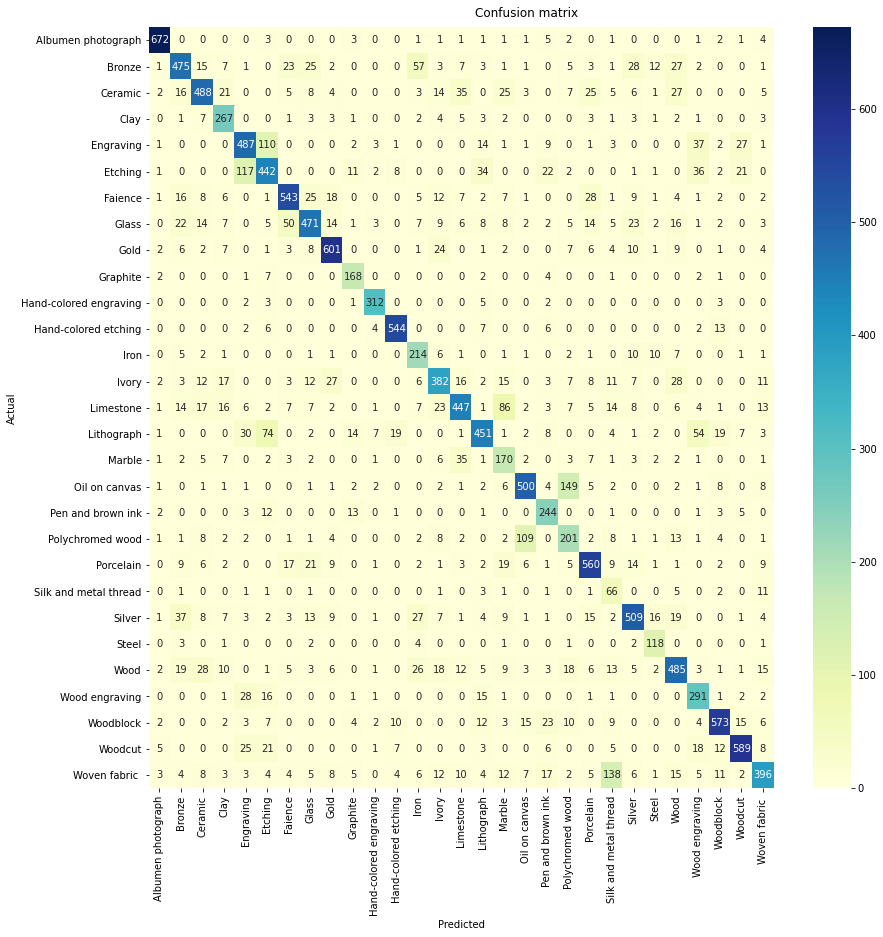

In [ ]:
df_cm = pd.DataFrame(
    confusion_matrix(test_generator.classes, y_pred),
    index=target_names,
    columns=target_names
)

df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig = plt.figure(figsize=(14, 14))
fig.suptitle("Confusion matrix", y=.9)
_ = sn.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt="d")

conv2d_28 (3, 3, 3, 8)


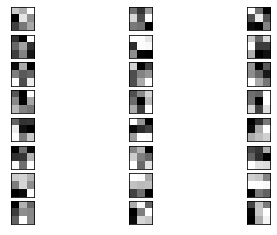

In [ ]:
import matplotlib.pyplot as plt
for layer in model1.layers:
  # check for convolutional layer
  if 'conv' not in layer.name:
    continue
    # get filter weights
  filters, biases = layer.get_weights()
  print(layer.name, filters.shape)
  f_min, f_max = filters.min(), filters.max()
  #filters = (filters - f_min) / (f_max - f_min)
 
  n_filters, ix = filters.shape[3], 1
  for i in range(n_filters):
	  # get the filter
	  f = filters[:, :, :, i]
	  # plot each channel separately
	  for j in range(3):
		  # specify subplot and turn of axis
		  ax = plt.subplot(n_filters, 3, ix)
		  ax.set_xticks([])
		  ax.set_yticks([])
		  # plot filter channel in grayscale
		  plt.imshow(f[:, :, j], cmap='gray')
		  ix += 1
  # show the figure
  plt.show()

## Evaluate the model

### Model

In [ ]:
# score = model.evaluate(validation_generator)
# print('test loss:', score[0])
# print('test accuracy:', score[1])

### Manual prediction

In [ ]:
# image = io.imread('./data_256/100158.jpg')
# classe = model.predict(np.array([image]))
# print(classe)